# K Nearest Neighbors - Choosing K

În partea trecută am învățat cum anume putem să creem un model de KNN. Cel mai important parametru al acestui model este cel de n_neighbors prin care îi spunem algoritmului la câte elemente apropiate să se uite pentru a stabili din ce categorie face parte. Acest număr este arbitrar și apare întrebarea cum anume putem seta cel mai potrivit număr. Pentru asta o să ne uităm la două metode diferite, și anume elbow metho și partea de cross-validation. Înainte de a ajunge la aceste părți o să ne mai uităm peste un concept din Scikit-Learn denumit Pipeline. Acest nou concept o să fie introdus în partea de cross-validation

Un Pipeline în Scikit-Learn reprezintă o serie de operații care se tot repetă. De obicei până acuma am scalat datele cu care lucrăm și după am creat modelul și l-am antrenat. Prin intermediul unui Pipeline putem să creem această serie de operații și să o apelăm fără a mai fi nevoiți să rescriem codul.

În continuare o să creem din nou un model de KNN simplu cu un singur n_neighbors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('../data/DATA/gene_expression.csv')

In [7]:
df

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1
...,...,...,...
2995,5.0,6.5,1
2996,3.4,6.6,0
2997,2.7,6.5,0
2998,3.3,5.6,0


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X = df.drop('Cancer Present', axis=1)
y = df['Cancer Present']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [11]:
from sklearn.preprocessing import StandardScaler

In [14]:
scaler = StandardScaler()

In [15]:
scaler.fit(X_train)

StandardScaler()

In [16]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
knn_model = KNeighborsClassifier(n_neighbors=1)

In [19]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [20]:
y_pred = knn_model.predict(X_test)

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
print(confusion_matrix(y_test, y_pred))

[[379  44]
 [ 35 442]]


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       423
           1       0.91      0.93      0.92       477

    accuracy                           0.91       900
   macro avg       0.91      0.91      0.91       900
weighted avg       0.91      0.91      0.91       900



Pentru început o să ne uităm peste metoda denumită elbow method. Această metodă este cea mai simplă și presupune crearea unei bucle for care să parcurgă mai multe valori pentru k. După ce se trece de o iterație se calculează eroarea acelui model care este defapt 1 - accuracy_score. La final o să avem o listă de erori, iar valoarea care este cea mai mică înseamnă că a performat cel mai bine

In [27]:
from sklearn.metrics import accuracy_score

test_error_scores = []

for k in range(1, 30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)

    test_error_scores.append(1 - accuracy_score(y_test, y_pred))

In [28]:
test_error_scores

[0.08777777777777773,
 0.09111111111111114,
 0.06999999999999995,
 0.06555555555555559,
 0.06555555555555559,
 0.06000000000000005,
 0.06333333333333335,
 0.06444444444444442,
 0.06555555555555559,
 0.06444444444444442,
 0.06777777777777783,
 0.06444444444444442,
 0.06666666666666665,
 0.06444444444444442,
 0.06777777777777783,
 0.06222222222222218,
 0.06000000000000005,
 0.061111111111111116,
 0.06222222222222218,
 0.06333333333333335,
 0.06222222222222218,
 0.06555555555555559,
 0.061111111111111116,
 0.05888888888888888,
 0.06222222222222218,
 0.06555555555555559,
 0.06222222222222218,
 0.061111111111111116,
 0.061111111111111116]

Text(0, 0.5, 'Error Rate')

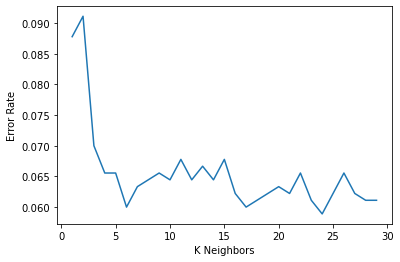

In [30]:
plt.plot(range(1, 30), test_error_scores)
plt.xlabel('K Neighbors')
plt.ylabel('Error Rate')

Din graficul de mai sus se poate observa că între valoarea de 5 și 30 pentru k, eroarea are cam o valoare constantă. Alegerea unei valori depinde de studiul de caz în parte, trebuie decis dacă dorim să avem un număr mai mare de k (ceea ce poate duce la un timp mai mare de rulare dacă avem un set de date extrem de mare) sau dacă dorim o performanță de viteză mai bună. Acest lucru depinde de la caz la caz. Metoda de mai sus este cea de elbow method și este considerată cea mai ușoară. Urmează partea în care o să ne folosim de cross-validation pentru a vedea ce valoare trebuie să setăm pentru k. Pentru a folosi cross-validation o să introducem și conceptul de Pipeline din Scikit-Learn

Pentru început o să ne setăm seria de operații care se va tot repeta, serie de operații pe care după o să le introducem în Pipeline. Ca și serie de operații o să avem:

1. Crearea unui Scaler

2. Crearea unui model

In [31]:
scaler = StandardScaler()
knn_model = KNeighborsClassifier()

Operațiile de mai sus reprezintă operațiile care formează un așa zis Pipeline. Următorul pas pe care trebuie să îl facem este să creem o variabilă în care să stocăm aceste operații. Variabila respectivă o să fie o listă de tuple. Fiecare tuplă o să fie alcătuită din două elemente, primul element o să fie reprezentat de un string, iar al doilea element o să fie variabila care realizează acea operație. De obicei, atât string-ul cât și numele variabile sunt aceleași. O să luăm exemplul de mai sus unde avem operațiile denumite scaler și knn_model. Primul element din cadrul listei o să fie o tuplă în care primul element din tuplă o să fie un string ce o să poarte denumirea de 'scaler', iar al doilea element o să fie obiectul de tip scaler

In [32]:
operations = [('sclaer', scaler), ('knn_model', knn_model)]

După ce am creat acel set de operații putem să ne creem Pipeline-ul. Pentru a crea un Pipeline acesta trebuie importat din modulul sklearn.pipeline și poartă denumirea de 'Pipeline'

In [33]:
from sklearn.pipeline import Pipeline

In [34]:
help(Pipeline)

Help on class Pipeline in module sklearn.pipeline:

class Pipeline(sklearn.utils.metaestimators._BaseComposition)
 |  Pipeline(steps, *, memory=None, verbose=False)
 |  
 |  Pipeline of transforms with a final estimator.
 |  
 |  Sequentially apply a list of transforms and a final estimator.
 |  Intermediate steps of the pipeline must be 'transforms', that is, they
 |  must implement `fit` and `transform` methods.
 |  The final estimator only needs to implement `fit`.
 |  The transformers in the pipeline can be cached using ``memory`` argument.
 |  
 |  The purpose of the pipeline is to assemble several steps that can be
 |  cross-validated together while setting different parameters. For this, it
 |  enables setting parameters of the various steps using their names and the
 |  parameter name separated by a `'__'`, as in the example below. A step's
 |  estimator may be replaced entirely by setting the parameter with its name
 |  to another estimator, or a transformer removed by setting

Acest obiect de tip Pipeline ia ca și argument 'steps', care reprezintă lista de tuple cu operațiile care trebuie realizate (poartă denumirea de operations)

In [35]:
pipeline = Pipeline(operations)

Următorul pas este să importăm GridSearchCV

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
k_values = list(range(1, 20))

Din moment ce utilizăm GridSearch trebuie să ne creem acel grid de parametrii pe care dorim să îi testăm. Înainte puteam să creem o astfel de variabilă după modelul următor:

In [38]:
param_grid = {'n_neighbors': k_values}

În momentul în care însă utilizăm un Pipeline nu mai putem să utilizăm aceeași structură pentru variabila respective. Acest comportament apare deoarece acel grid search nu știe pentru ce operație din Pipeline este setat parametrul de 'n_neighbors'. Pentru a rezolva această problemă, pentru a putea seta anumite valori de parametrii pentru diferite operații din Pipeline, atunci există următoarea convenție:

choosen_string_name + two underscores + parameter name

În acest grid o să dorim să facem un grid search pentru parametrul de 'n_neighbors' de la modelul de clasificare (KNN). Dacă ne uităm în lista de operații, inițializarea unui model de KNN poartă denumirea de 'knn_model'. Prin urmare 'choosen_strin_name' o să fie înlocuit cu 'knn_model'. După asta o să adăugăm double underscore, iar după double underscore vine numele parametrului pe care dorim să îl testăm cu diferite valori.

In [39]:
param_grid = {'knn_model__n_neighbors' : k_values}

Din moment ce acuma avem și variabila de param_grid putem să creem acel grid search. Înainte însă de a crea acest GridSearch o să realizăm din nou partea de train_test_split. O să facem asta deoarece Pipeline-ul pe care l-am creat are și partea de scalare de date, iar în acest moment avem doar datele scalate. Pentru a avea un set de date nou și corect (adică pentru a scala datele de două ori) o să realizăm din nou partea de train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

Acuma o să creem grid search-ul. În loc de model (cum se făcea partea de grid search înainte), acuma o să trecem variabila pipeline

In [41]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

In [42]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sclaer', StandardScaler()),
                                       ('knn_model', KNeighborsClassifier())]),
             param_grid={'knn_model__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                    10, 11, 12, 13, 14, 15, 16,
                                                    17, 18, 19]},
             scoring='accuracy')

După ce am realizat partea de grid search putem să vedem care sunt parametrii celui mai bun estimator

In [43]:
grid_search.best_estimator_.get_params()

{'memory': None,
 'steps': [('sclaer', StandardScaler()),
  ('knn_model', KNeighborsClassifier(n_neighbors=19))],
 'verbose': False,
 'sclaer': StandardScaler(),
 'knn_model': KNeighborsClassifier(n_neighbors=19),
 'sclaer__copy': True,
 'sclaer__with_mean': True,
 'sclaer__with_std': True,
 'knn_model__algorithm': 'auto',
 'knn_model__leaf_size': 30,
 'knn_model__metric': 'minkowski',
 'knn_model__metric_params': None,
 'knn_model__n_jobs': None,
 'knn_model__n_neighbors': 19,
 'knn_model__p': 2,
 'knn_model__weights': 'uniform'}

Estimatorul respectiv putem să îl utilizăm acuma pentru a face predicții, fie pe setul de date de testare, fie pe un nou pacient. Datele asupra cărora o să facem predict nu mai trebuie scalate deoarece partea de scalare este deja preszentă în Pipeline

## Recapitulare

În cadrul acestei lecții am învățat următoarele lucruri:

    1. Care sunt metodele pe care le putem utiliza pentru a găsi cea mai bună valoare pentru k (n_neighbors)

        - elbow method

        - cross validation (împreună cu Pipeline)

    2. Elbow Method pentru a afla valoarea cea mai potrivită pentru k

        from sklearn.metrics import accuracy_score

        test_error_scores = []

        for k in range(1, 30):

            knn_model = KNeighborsClassifier(n_neighbors=k)

            knn_model.fit(X_train, y_train)

            y_pred = knn_model.predict(X_test)

            test_error_scores.append(1 - accuracy_score(y_test, y_pred))

    3. Ce este un Pipeline

        O serie de operații repretitive pe care putem să le introducem într-un bloc de cod

    4. De unde să importăm un Pipeline în Scikit-Learn

        from sklearn.pipeline import Pipeline

    5. Pipeline-ul are nevoie de o listă de operații. Operațiile sunt structurate în tuple în care prima valoare este un string arbitrat, iar cea de a doua valoare este operația care trebuie să se ruleze (crearea unui model, crearea unui scaler). De obicei aceste valori sunt identice

        scaler = StandardScaler()

        knn_model = KNeighborsClassifier()

        operations = [('scaler', scaler), ('knn_model', knn_model)]

    6. Cum să creem o variabilă de tip Pipeline

        pipeline = Pipeline(steps=operations)

    7. Pipeline-ul se utilizează împreună cu un GridSearchCV

        from sklearn.model_selection import GridSearchCV

    8. Pentru a putea utiliza Pipeline-ul în GridSearchCV trebuie să modificăm modul în care oferim denumirea parametrilor în cadrul variabilei param_grid. Trebuie să specificăm pentru care dintre acțiunile din Pipeline este parametrul respectiv. Pentru asta se urmează o convecție

        choosen_string_name + two underscores + parameter name

        param_grid = {'knn_model__n_neighbors' : k_values}

    9. Variabila de tip Pipeline se va trece în GridSearchCV în loc de estimator, iar aceasta se va ocupa și cu partea de scalare de date.

        grid_seach = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

        